# The Oslo Model (Self-organized Criticality)

In [1]:
from OsloModel import OsloModel
from OsloModelNumba import OsloModelNumba
from OsloModelFunctions import *
from matplotlib import pyplot as plt
import numpy as np
import numba as nb
import timeit
from time import time

In [2]:
L = 100
grains = 1000

In [3]:
%%timeit
OsloModel(L=L, grains=grains)

3.28 µs ± 50 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [4]:
%%timeit
OsloModelNumba(L=L, grains=grains)

The slowest run took 4.57 times longer than the fastest. This could mean that an intermediate result is being cached.
22.3 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
model = OsloModel(L=L, grains=grains)
modelNumba = OsloModelNumba(L=L, grains=grains)

In [6]:
%%timeit
model.add_all_grains(random_increment=True)

5.21 s ± 79.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
modelNumba.add_all_grains(True)

5.3 ms ± 74.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Avalanche size in function of time

In [8]:
L = 2000
grains = 4000
random_increment = False
left_wall_closed = True
modelNumba = OsloModelNumba(L=L, grains=grains, left_wall_closed=left_wall_closed)

In [9]:
start_time = time()
modelNumba.add_all_grains(random_increment)
time_delta = time() - start_time
time_delta

21.031995058059692

In [10]:
steps, avalanche = modelNumba.get_plot_data()
print(len(steps), len(avalanche))

4000 4000


Text(0.5, 1.0, '$S(t)$ with left-most incrementation and left wall closed\nL = 2000, number of grains: 4000, biggest avalanche: 79447960')

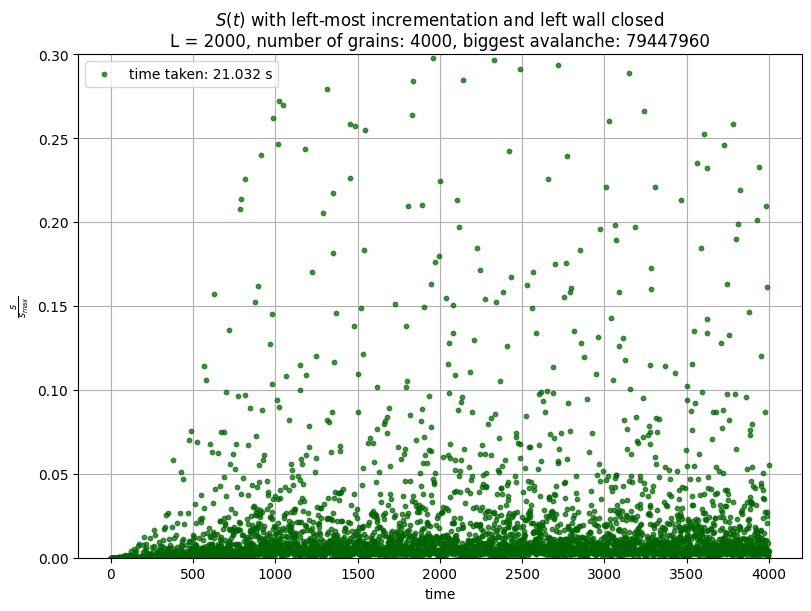

In [11]:
figure1, axes1 = plt.subplots(layout='constrained', figsize=(8, 6))
plot_avalanche_size_scatter(modelNumba, time_delta, axes=axes1, ylim=.3, alpha=.7, color='darkgreen')
axes1.set_title(f'$S(t)$ with left-most incrementation and left wall closed\n'
                f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}')

In [12]:
figure1.savefig(f'images/AvalancheSizeLeftmostWallclosedL{L}G{grains}.png')

In [13]:
L = 2000
grains = 4000
random_increment = True
left_wall_closed = False
modelNumba = OsloModelNumba(L=L, grains=grains, left_wall_closed=left_wall_closed)

start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
steps, avalanche = modelNumba.get_plot_data()

Text(0.5, 1.0, '$S(t)$ with random incrementation and left wall opened\nL = 2000, number of grains: 4000, biggest avalanche: 9055324')

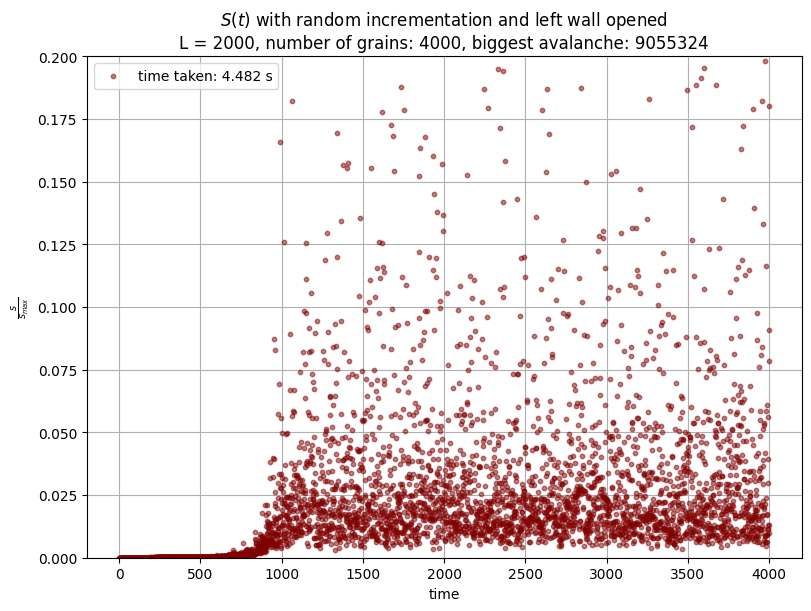

In [14]:
figure2, axes2 = plt.subplots(layout='constrained', figsize=(8, 6))
plot_avalanche_size_scatter(modelNumba, time_delta, axes=axes2, ylim=.2, alpha=.5, color='maroon')
axes2.set_title(f'$S(t)$ with random incrementation and left wall opened\n'
                f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}')

In [15]:
figure2.savefig(f'images/AvalancheSizeRandomWallopenedL{L}G{grains}.png')

In [16]:
L = 4000
grains = 8000
random_increment = False
left_wall_closed = False
modelNumba = OsloModelNumba(L=L, grains=grains, left_wall_closed=left_wall_closed)

start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
steps, avalanche = modelNumba.get_plot_data()

Text(0.5, 1.0, '$S(t)$ with left-most incrementation and left wall opened\nL = 4000, number of grains: 8000, biggest avalanche: 1176')

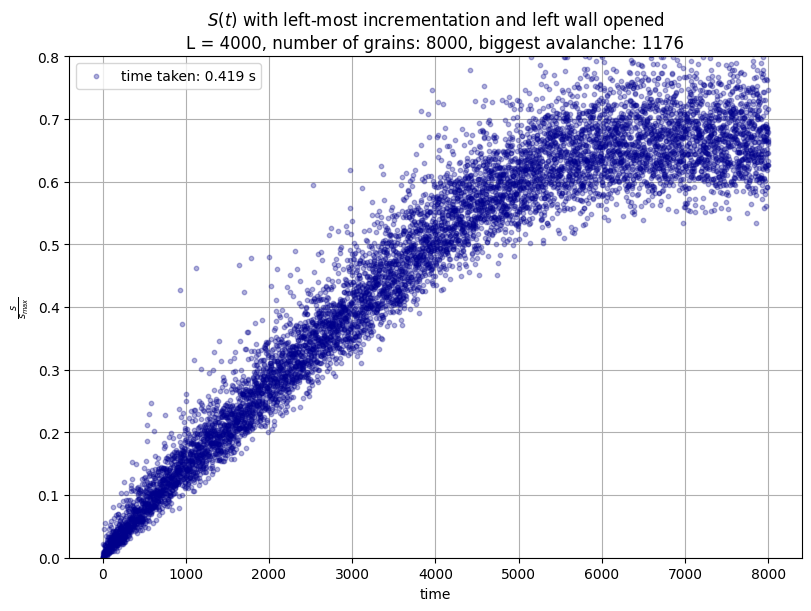

In [17]:
figure3, axes3 = plt.subplots(layout='constrained', figsize=(8, 6))
plot_avalanche_size_scatter(modelNumba, time_delta, axes=axes3, ylim=.8, alpha=.3, color='darkblue')
axes3.set_title(f'$S(t)$ with left-most incrementation and left wall opened\n'
                f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}')

In [18]:
figure3.savefig(f'images/AvalancheSizeLeftmostWallopenedL{L}G{grains}.png')

## We can also notice a sinusoidal behavior for larger number of grains

In [19]:
L = 1000
grains = 20000
random_increment = False
left_wall_closed = False
modelNumba = OsloModelNumba(L=L, grains=grains, left_wall_closed=left_wall_closed)

start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
steps, avalanche = modelNumba.get_plot_data()

Text(0.5, 1.0, '$S(t)$ with left-most incrementation and left wall opened\nL = 1000, number of grains: 20000, biggest avalanche: 1160')

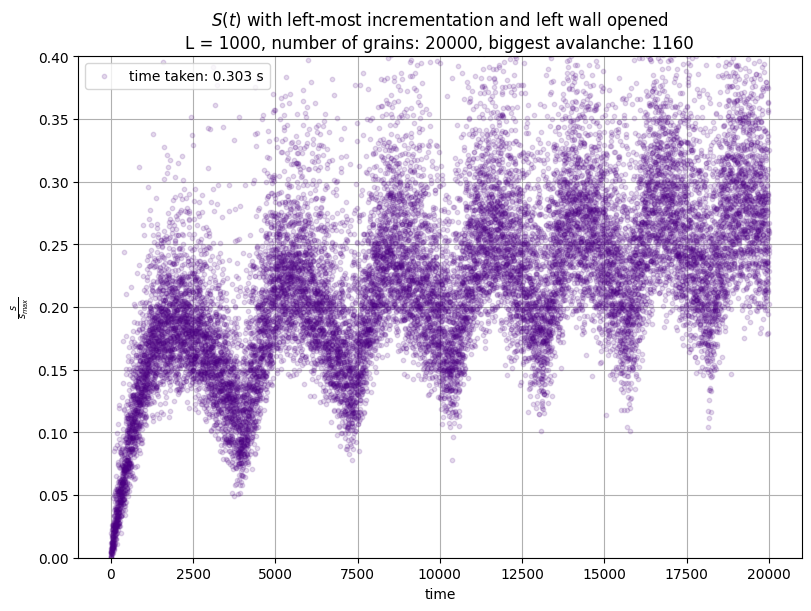

In [20]:
figure4, axes4 = plt.subplots(layout='constrained', figsize=(8, 6))
plot_avalanche_size_scatter(modelNumba, time_delta, axes=axes4, ylim=.4, alpha=.15, color='indigo')
axes4.set_title(f'$S(t)$ with left-most incrementation and left wall opened\n'
                f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}')

In [21]:
figure4.savefig(f'images/AvalancheSizeLeftmostWallopenedL{L}G{grains}.png')

# Avalanche size probability

In [22]:
%%timeit
calculate_avalanche_probabilities_with_trials(400, 2000, 10, False, False)

108 ms ± 949 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
L_list = [150, 300, 500, 1000, 2000]
grains = 6000
colors = ['maroon', 'darkgreen', 'darkblue', 'gold', 'indigo']
trials = 100
is_incremented_randomly = False
is_left_wall_closed = False

Text(0.5, 1.0, '$P(s, L)$, 6000 grains, 100 trials, left wall opened')

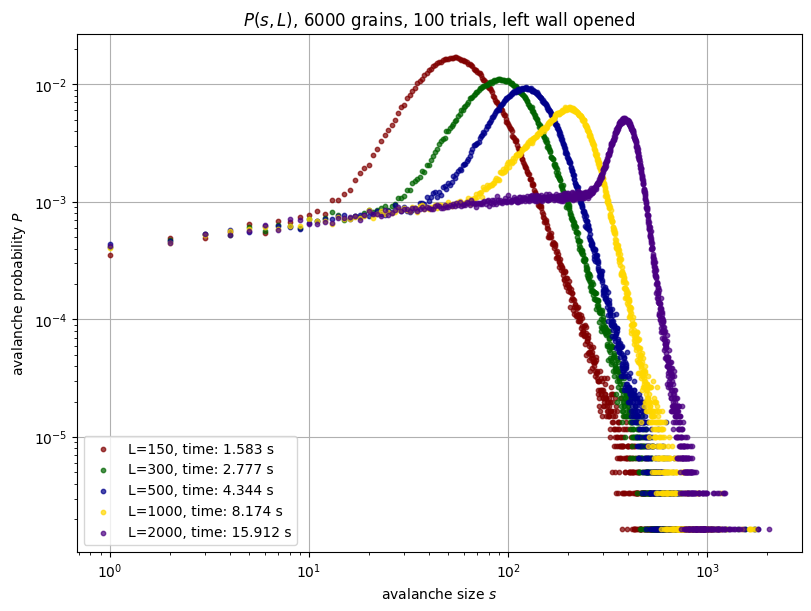

In [24]:
figure5, axes5 = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
for index, L in enumerate(L_list):
    start_time = time()
    avalanche_count = calculate_avalanche_probabilities_with_trials(L_list[index], grains, trials, 
                                                                    is_incremented_randomly, is_left_wall_closed)
    time_delta = time() - start_time
    plot_scatter_histogram(L, np.arange(len(avalanche_count)), avalanche_count, 
                           time_delta, axes=axes5, color=colors[index])
axes5.set_title(f'$P(s, L)$, {grains} grains, {trials} trials, left wall opened')

In [25]:
figure5.savefig(f'images/AvalancheProbabilityLeftmostWallclosedL{L}G{grains}T{trials}.png')

In [26]:
grains = 15000
bins = 2000
is_incremented_randomly = False
is_left_wall_closed = True

Text(0.5, 1.0, '$P(s, L)$, 15000 grains, left wall closed')

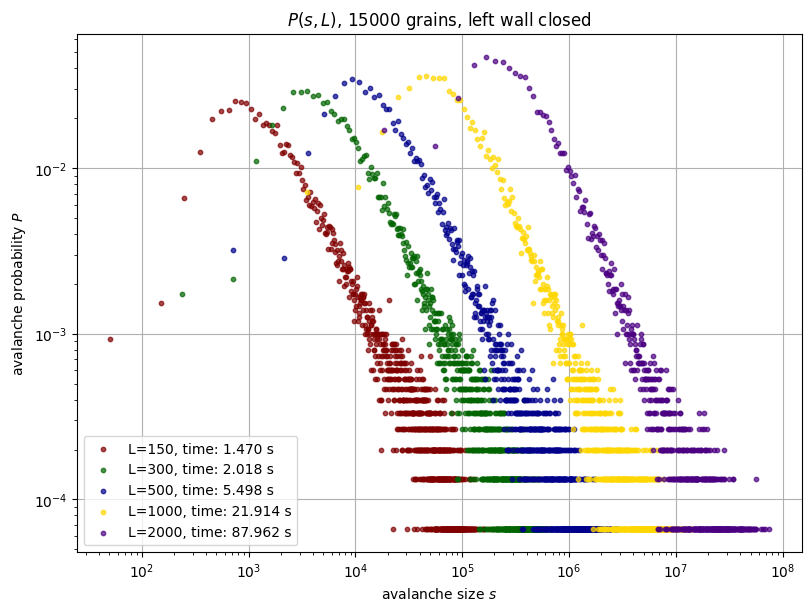

In [27]:
figure6, axes6 = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
for index, L in enumerate(L_list):
    start_time = time()
    modelNumba = OsloModelNumba(L=L, grains=grains, left_wall_closed=is_left_wall_closed)
    modelNumba.add_all_grains(is_incremented_randomly)
    avalanche_bins, avalanche_count = modelNumba.calculate_avalanche_histogram(bins)
    time_delta = time() - start_time
    plot_scatter_histogram(L, avalanche_bins, avalanche_count / modelNumba.grains,
                           time_delta, axes=axes6, color=colors[index])
axes6.set_title(f'$P(s, L)$, {grains} grains, left wall closed')

In [28]:
figure6.savefig(f'images/AvalancheProbabilityLeftmostWallopenedL{L}G{grains}T{trials}.png')

# System's time evolution visualization

In [29]:
L = 500
steps = 500
is_incremented_randomly = False
is_left_wall_closed = True
evo_grid, steps_array, avalanche = simulate_time_evolution(L, steps, is_incremented_randomly, threshold=(1, 2),
                                                           left_wall_closed=is_left_wall_closed)

Text(0.5, 0.98, 'Time evolution of the system and avalanche size\nleft-most incrementation, left wall closed\nL=500, 500 grains, biggest_avalanche: 2237492, ylim=0.3')

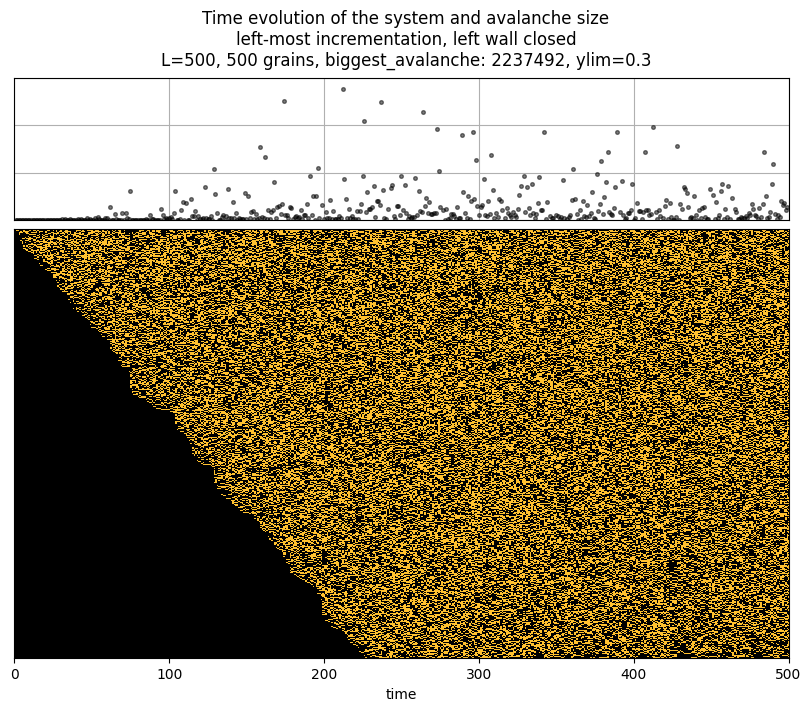

In [30]:
ylim = 0.3
figure7, axes7 = plt.subplots(2, 1, layout='constrained', height_ratios=[1, 3], figsize=(8, 7))
plot_avalanche_size(steps, steps_array, avalanche, axes=axes7[0], ylim=ylim)
plot_time_evolution(L, steps, evo_grid, axes=axes7[1])
figure7.suptitle(f'Time evolution of the system and avalanche size\n'
                 f'left-most incrementation, left wall closed\n'
                 f'L={L}, {steps} grains, biggest_avalanche: {avalanche.max()}, ylim={ylim}')

In [31]:
figure7.savefig(f'images/SystemVisualizationLeftmostWallclosedL{L}G{steps}.png')

In [32]:
L = 500
steps = 500
is_incremented_randomly = True
evo_grid, steps_array, avalanche = simulate_time_evolution(L, steps, is_incremented_randomly, threshold=(1, 2))

Text(0.5, 0.98, 'Time evolution of the system and avalanche size\nrandom incrementation, left wall opened\nL=500, 500 grains, biggest_avalanche: 602174, ylim=0.1')

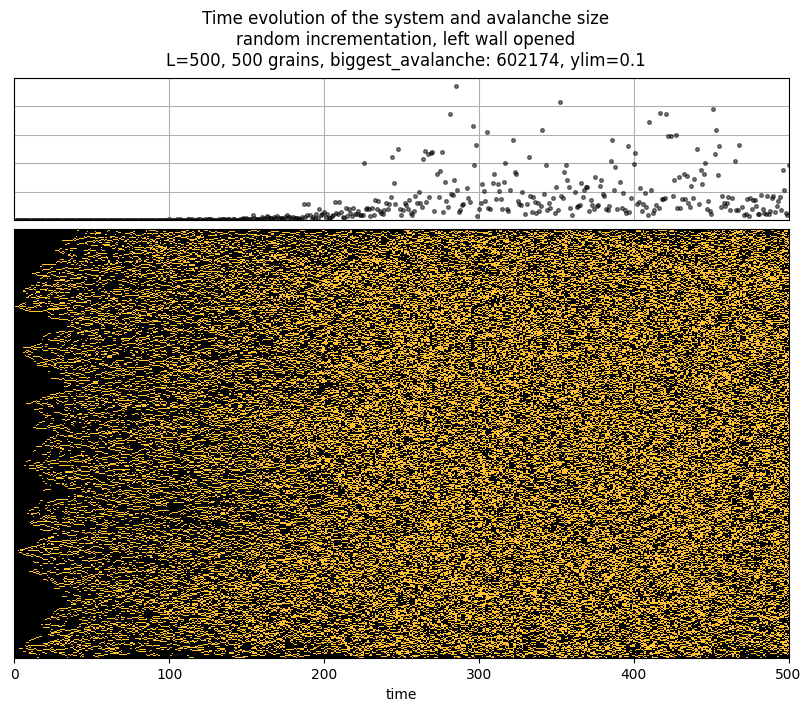

In [33]:
ylim = 0.1
figure8, axes8 = plt.subplots(2, 1, layout='constrained', height_ratios=[1, 3], figsize=(8, 7))
plot_avalanche_size(steps, steps_array, avalanche, axes=axes8[0], ylim=ylim)
plot_time_evolution(L, steps, evo_grid, axes=axes8[1])
figure8.suptitle(f'Time evolution of the system and avalanche size\n'
                 f'random incrementation, left wall opened\n'
                 f'L={L}, {steps} grains, biggest_avalanche: {avalanche.max()}, ylim={ylim}')

In [34]:
figure8.savefig(f'images/SystemVisualizationRandomWallopenedL{L}G{steps}.png')

In [35]:
L = 500
steps = 1000
is_incremented_randomly = False
evo_grid, steps_array, avalanche = simulate_time_evolution(L, steps, is_incremented_randomly, threshold=(1, 2))

Text(0.5, 0.98, 'Time evolution of the system and avalanche size.\nleft-most, left wall opened\nL=500, 1000 grains, biggest_avalanche: 425, ylim=0.6')

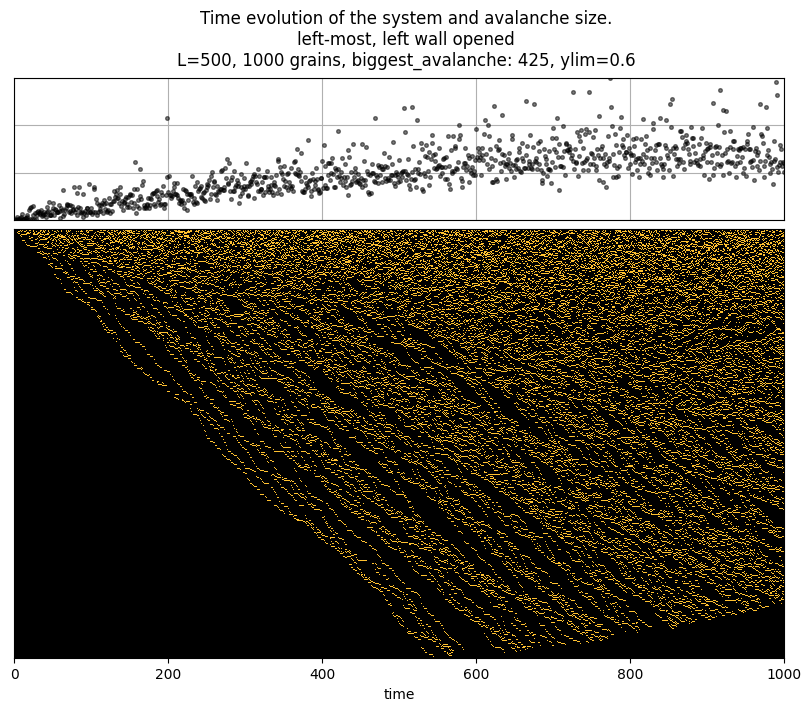

In [36]:
ylim = 0.6
figure9, axes9 = plt.subplots(2, 1, layout='constrained', height_ratios=[1, 3], figsize=(8, 7))
plot_avalanche_size(steps, steps_array, avalanche, axes=axes9[0], ylim=ylim)
plot_time_evolution(L, steps, evo_grid, axes=axes9[1])
figure9.suptitle(f'Time evolution of the system and avalanche size.\n'
                 f'left-most, left wall opened\n'
                 f'L={L}, {steps} grains, biggest_avalanche: {avalanche.max()}, ylim={ylim}')

In [37]:
figure9.savefig(f'images/SystemVisualizationLeftmostWallopenedL{L}G{steps}.png')

In [38]:
L = 500
steps = 5000
is_incremented_randomly = False
evo_grid, steps_array, avalanche = simulate_time_evolution(L, steps, is_incremented_randomly, threshold=(1, 2))

Text(0.5, 0.98, 'Time evolution of the system and avalanche size.\nleft-most, left wall opened\nL=500, 5000 grains, biggest_avalanche: 800, ylim=0.4')

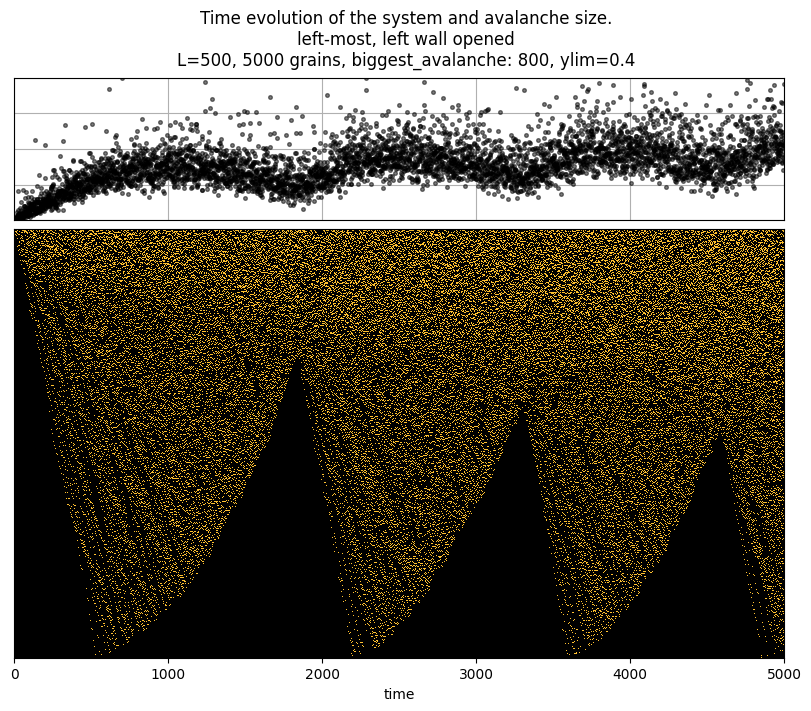

In [39]:
ylim = 0.4
figure10, axes10 = plt.subplots(2, 1, layout='constrained', height_ratios=[1, 3], figsize=(8, 7))
plot_avalanche_size(steps, steps_array, avalanche, axes=axes10[0], ylim=ylim)
plot_time_evolution(L, steps, evo_grid, axes=axes10[1])
figure10.suptitle(f'Time evolution of the system and avalanche size.\n'
                  f'left-most, left wall opened\n'
                  f'L={L}, {steps} grains, biggest_avalanche: {avalanche.max()}, ylim={ylim}')

In [40]:
figure10.savefig(f'images/SystemVisualizationLeftmostWallopenedL{L}G{steps}.png')